<a href="https://colab.research.google.com/github/180030814-GnaneshwarReddy/GnaneswaraReddy_INFO5731_Fall2024/blob/main/Palem_Gnaneswara_Exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [4]:
# Write your code here
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
import gensim
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

def load_data(filepath):
    labels = []
    reviews = []
    with open(filepath, 'r') as file:
        for line in file:
            label = int(line[0])
            review = line[2:].strip()
            labels.append(label)
            reviews.append(review)
    return pd.DataFrame({'label': labels, 'text': reviews})

train_df = load_data("/content/stsa-train.txt")
test_df = load_data("/content/stsa-test.txt")

X_train_full = train_df['text']
y_train_full = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

def generate_word2vec_embeddings(text_data):
    tokenized_text = [text.split() for text in text_data]
    word2vec_model = gensim.models.Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
                                   or [np.zeros(100)], axis=0) for words in tokenized_text])
    return embeddings

def generate_bert_embeddings(text_data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    embeddings = []
    for text in text_data:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(cls_embedding.flatten())
    return np.array(embeddings)

models = {
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(kernel='linear', probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

evaluation_results = {}
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('classifier', model),
    ])


    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)
    accuracy = metrics.accuracy_score(y_val, y_val_pred)
    precision = metrics.precision_score(y_val, y_val_pred, average='binary')
    recall = metrics.recall_score(y_val, y_val_pred, average='binary')
    f1 = metrics.f1_score(y_val, y_val_pred, average='binary')

    evaluation_results[model_name] = {
        'Cross-Validation Accuracy': cv_scores.mean(),
        'Validation Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

word2vec_train_embeddings = generate_word2vec_embeddings(X_train)
word2vec_val_embeddings = generate_word2vec_embeddings(X_val)

word2vec_svm = SVC(kernel='linear')
word2vec_svm.fit(word2vec_train_embeddings, y_train)
y_val_pred_word2vec = word2vec_svm.predict(word2vec_val_embeddings)
evaluation_results['Word2Vec SVM'] = {
    'Validation Accuracy': metrics.accuracy_score(y_val, y_val_pred_word2vec),
    'Precision': metrics.precision_score(y_val, y_val_pred_word2vec),
    'Recall': metrics.recall_score(y_val, y_val_pred_word2vec),
    'F1 Score': metrics.f1_score(y_val, y_val_pred_word2vec)
}

bert_train_embeddings = generate_bert_embeddings(X_train)
bert_val_embeddings = generate_bert_embeddings(X_val)

bert_svm = SVC(kernel='linear')
bert_svm.fit(bert_train_embeddings, y_train)
y_val_pred_bert = bert_svm.predict(bert_val_embeddings)
evaluation_results['BERT SVM'] = {
    'Validation Accuracy': metrics.accuracy_score(y_val, y_val_pred_bert),
    'Precision': metrics.precision_score(y_val, y_val_pred_bert),
    'Recall': metrics.recall_score(y_val, y_val_pred_bert),
    'F1 Score': metrics.f1_score(y_val, y_val_pred_bert)
}

for model_name, metrics in evaluation_results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Model: Naive Bayes
Cross-Validation Accuracy: 0.7666
Validation Accuracy: 0.7782
Precision: 0.7355
Recall: 0.8892
F1 Score: 0.8051

Model: Support Vector Machine
Cross-Validation Accuracy: 0.7581
Validation Accuracy: 0.7919
Precision: 0.7792
Recall: 0.8317
F1 Score: 0.8046

Model: K-Nearest Neighbors
Cross-Validation Accuracy: 0.5233
Validation Accuracy: 0.4964
Precision: 0.5089
Recall: 0.6381
F1 Score: 0.5663

Model: Decision Tree
Cross-Validation Accuracy: 0.6347
Validation Accuracy: 0.6525
Precision: 0.6394
Recall: 0.7461
F1 Score: 0.6887

Model: Random Forest
Cross-Validation Accuracy: 0.7083
Validation Accuracy: 0.7399
Precision: 0.7215
Recall: 0.8065
F1 Score: 0.7616

Model: XGBoost
Cross-Validation Accuracy: 0.6783
Validation Accuracy: 0.6944
Precision: 0.6586
Recall: 0.8443
F1 Score: 0.7400

Model: Word2Vec SVM
Validation Accuracy: 0.4877
Precision: 1.0000
Recall: 0.0056
F1 Score: 0.0112

Model: BERT SVM
Validation Accuracy: 0.8533
Precision: 0.8512
Recall: 0.8668
F1 Score: 0.

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

KMeans Silhouette Score (TF-IDF): 0.0227


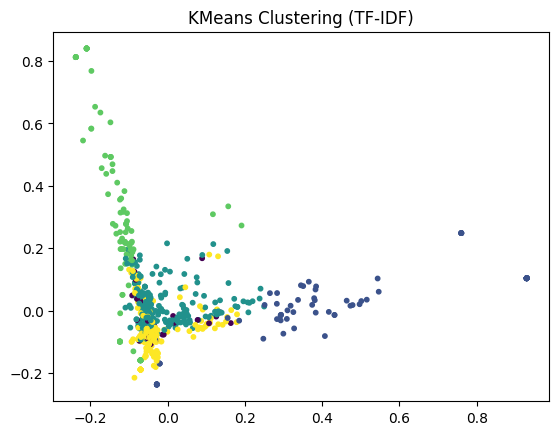

DBSCAN Silhouette Score: 0.0306


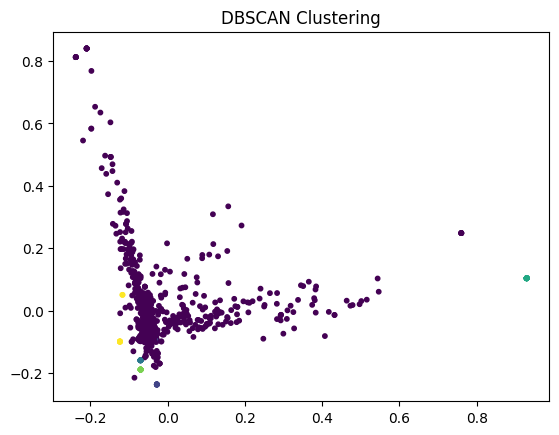

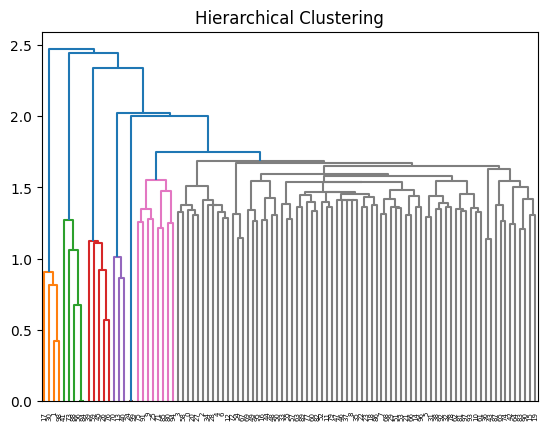

KMeans Silhouette Score (Word2Vec): 0.5401


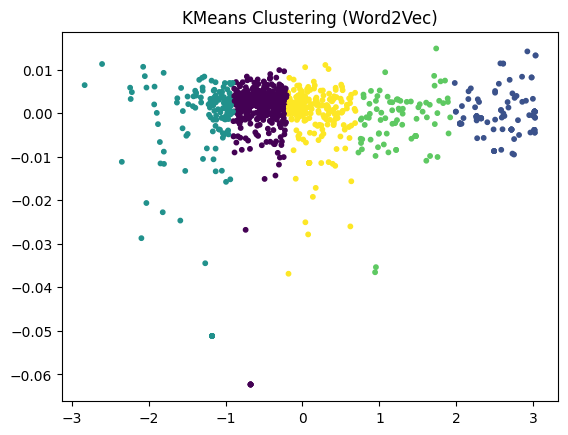

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

KMeans Silhouette Score (BERT): 0.0474


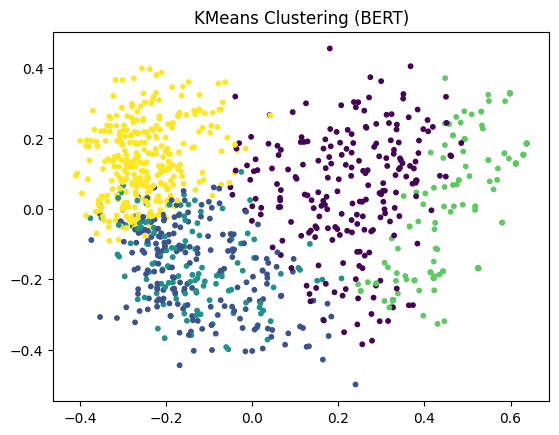

In [5]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

data = pd.read_csv("Amazon_Unlocked_Mobile.csv")
data = data.dropna(subset=['Reviews'])
data = data.sample(1000, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(data['Reviews']).toarray()

kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_tfidf_labels = kmeans_model.fit_predict(tfidf_features)
print(f"KMeans Silhouette Score (TF-IDF): {silhouette_score(tfidf_features, kmeans_tfidf_labels):.4f}")

pca_model = PCA(n_components=2)
tfidf_reduced_data = pca_model.fit_transform(tfidf_features)
plt.scatter(tfidf_reduced_data[:, 0], tfidf_reduced_data[:, 1], c=kmeans_tfidf_labels, cmap='viridis', s=10)
plt.title('KMeans Clustering (TF-IDF)')
plt.show()

dbscan_model = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan_model.fit_predict(tfidf_features)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(tfidf_features, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("DBSCAN did not form distinct clusters.")

plt.scatter(tfidf_reduced_data[:, 0], tfidf_reduced_data[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title('DBSCAN Clustering')
plt.show()

hierarchical_sample = tfidf_features[:100]
linkage_matrix = linkage(hierarchical_sample, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering')
plt.show()

tokenized_text = [review.split() for review in data['Reviews']]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)
word2vec_features = np.array([np.mean([word2vec_model.wv[word] for word in review if word in word2vec_model.wv]
                                      or [np.zeros(100)], axis=0) for review in tokenized_text])

kmeans_word2vec_labels = kmeans_model.fit_predict(word2vec_features)
print(f"KMeans Silhouette Score (Word2Vec): {silhouette_score(word2vec_features, kmeans_word2vec_labels):.4f}")

word2vec_reduced_data = pca_model.fit_transform(word2vec_features)
plt.scatter(word2vec_reduced_data[:, 0], word2vec_reduced_data[:, 1], c=kmeans_word2vec_labels, cmap='viridis', s=10)
plt.title('KMeans Clustering (Word2Vec)')
plt.show()

bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_features = bert_model.encode(data['Reviews'].tolist(), show_progress_bar=True)

kmeans_bert_labels = kmeans_model.fit_predict(bert_features)
print(f"KMeans Silhouette Score (BERT): {silhouette_score(bert_features, kmeans_bert_labels):.4f}")

bert_reduced_data = pca_model.fit_transform(bert_features)
plt.scatter(bert_reduced_data[:, 0], bert_reduced_data[:, 1], c=kmeans_bert_labels, cmap='viridis', s=10)
plt.title('KMeans Clustering (BERT)')
plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

Each strategy has distinct qualities that are shown by the clustering results. K-means effectively creates discrete groups using Word2Vec and BERT embeddings, displaying unique and significant clusters. However, DBSCAN has trouble with sparse and high-dimensional text input, frequently perceiving other points as noise and allocating the majority of points to a single, sizable cluster. Although detailed dendrograms are produced via hierarchical clustering, these are more difficult to understand and do not distinguish between groups in higher dimensions. Word2Vec and K-means together illustrate semantic relationships between clusters in lower dimensions. Due to their ability to capture fine-grained semantic links, BERT embeddings with K-means produce cluster separations that are even more meaningful and apparent.



# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
I learned how to implement algorithms like MultinominalNB, SVM, KNN, Decision tree,
Random Forest, XGBoost, Word2Vec, and BERT and evaluate their corresponding measurements in the assignment's
first question. I had to try several machine learning algorithms for text clustering in the second question.
Apart from the fact that everything went without a hitch, I took a while to execute the code for the first question.





'''